In [1]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt

## Set the seed for reproducibility

In [2]:
SEED = 44
np.random.seed(SEED)
random.seed(SEED)

## Load the data

In [3]:
import os

data_path = "data/features/genimage/standard"
biggan_train = pd.read_csv(os.path.join(data_path, "imagenet_ai_0419_biggan/train/features_RGB.csv"), index_col=0)
vqdm_train = pd.read_csv(os.path.join(data_path, "imagenet_ai_0419_vqdm/train/features_RGB.csv"), index_col=0)
sdv5_train = pd.read_csv(os.path.join(data_path, "imagenet_ai_0424_sdv5/train/features_RGB.csv"), index_col=0)
wukong_train = pd.read_csv(os.path.join(data_path, "imagenet_ai_0424_wukong/train/features_RGB.csv"), index_col=0)
adm_train = pd.read_csv(os.path.join(data_path, "imagenet_ai_0508_adm/train/features_RGB.csv"), index_col=0)
glide_train = pd.read_csv(os.path.join(data_path, "imagenet_glide/train/features_RGB.csv"), index_col=0)
midjourney_train = pd.read_csv(os.path.join(data_path, "imagenet_midjourney/train/features_RGB.csv"), index_col=0)
mid_sd = pd.concat([sdv5_train, midjourney_train])
combined_train = pd.concat([biggan_train, vqdm_train, sdv5_train, wukong_train, adm_train, glide_train, midjourney_train])

datasets_train = {
    "biggan": biggan_train,
    "vqdm": vqdm_train,
    "sdv5": sdv5_train,
    "wukong": wukong_train,
    "adm": adm_train,
    "glide": glide_train,
    "midjourney": midjourney_train,
    "mid_sd": mid_sd,
    "combined": combined_train,
}

In [39]:
biggan_test = pd.read_csv(os.path.join(data_path, "imagenet_ai_0419_biggan/val/features_RGB.csv"), index_col=0)
vqdm_test = pd.read_csv(os.path.join(data_path, "imagenet_ai_0419_vqdm/val/features_RGB.csv"), index_col=0)
sdv5_test = pd.read_csv(os.path.join(data_path, "imagenet_ai_0424_sdv5/val/features_RGB.csv"), index_col=0)
wukong_test = pd.read_csv(os.path.join(data_path, "imagenet_ai_0424_wukong/val/features_RGB.csv"), index_col=0)
adm_test = pd.read_csv(os.path.join(data_path, "imagenet_ai_0508_adm/val/features_RGB.csv"), index_col=0)
glide_test = pd.read_csv(os.path.join(data_path, "imagenet_glide/val/features_RGB.csv"), index_col=0)
midjourney_test = pd.read_csv(os.path.join(data_path, "imagenet_midjourney/val/features_RGB.csv"), index_col=0)
mid_sd = pd.concat([sdv5_test, midjourney_test])
combined_test = pd.concat([biggan_test, vqdm_test, sdv5_test, wukong_test, adm_test, glide_test, midjourney_test])

datasets_test = {
    "biggan": biggan_test,
    "vqdm": vqdm_test,
    "sdv5": sdv5_test,
    "wukong": wukong_test,
    "adm": adm_test,
    "glide": glide_test,
    "midjourney": midjourney_test,
    "mid_sd": mid_sd,
    "combined": combined_test,
}

## Data preparation

In [5]:
def drop_columns(df, drop_only_diagnostic=False):
    for column in df.columns:
        if df[column].min() == df[column].max() and not drop_only_diagnostic:
            df.drop(column, axis=1, inplace=True)
        elif 'diagnostics' in column:
            df.drop(column, axis=1, inplace=True)
        elif 'Mask' in column:
            df.drop(column, axis=1, inplace=True)
            
def preprocess_dataset(df, **kwargs):
    # print indexes and image names of rows with NaN values
    nans = df[df.isnull().any(axis=1)]['Image'].apply(lambda x : x.split('/')[-1])
    if not nans.empty:
        print(f"Rows with NaN values:")
        print(nans)
    df.dropna(inplace=True)  
    drop_columns(df, **kwargs)
    
def unify_columns(base_columns, df):
    # drop columns that are not in base_columns
    for column in df.columns:
        if column not in base_columns:
            df.drop(column, axis=1, inplace=True)

### Drop unimportant columns

In [6]:
# We drop only columns from train set
for key, df in datasets_train.items():
    preprocess_dataset(df, drop_only_diagnostic=True)

Rows with NaN values:
2726    006_biggan_00182.png
2842    107_biggan_00008.png
Name: Image, dtype: object
Rows with NaN values:
2726    006_biggan_00182.png
2842    107_biggan_00008.png
Name: Image, dtype: object


### Split into train and test set

In [7]:
from sklearn.model_selection import train_test_split

X_train = {}
X_val = {}

y_train = {}
y_val = {}

Image_train = {}
Image_val = {}

for key, df in datasets_train.items():
    X = df.drop('Category', axis=1)
    y = df['Category']
    
    X_train[key], X_val[key], y_train[key], y_val[key] = train_test_split(X, y, test_size=0.2, random_state=SEED)
    
    Image_train[key] = X_train[key]['Image']
    Image_val[key] = X_val[key]['Image']
    
    X_train[key] = X_train[key].drop('Image', axis=1)
    X_val[key] = X_val[key].drop('Image', axis=1)

### Scale the data

In [8]:
from sklearn.preprocessing import MinMaxScaler

scalers = {}
X_train_scaled = {}
for key in datasets_train.keys():
    scalers[key] = MinMaxScaler()
    X_train_scaled[key] = scalers[key].fit_transform(X_train[key])
    X_train_scaled[key] = pd.DataFrame(X_train_scaled[key], columns=X_train[key].columns)

## Model training

In [9]:
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import LinearSVC

models = {}
for dataset_name in datasets_train.keys():
    print(f"\n\nTraining set: {dataset_name}\n")

    models_temp = [
        HistGradientBoostingClassifier(random_state=SEED),
        LinearDiscriminantAnalysis(),
        RandomForestClassifier(random_state=SEED),
        LinearSVC(random_state=SEED)
    ]

    model_temp_dict = { model.__class__.__name__: model for model in models_temp }

    for name, model in model_temp_dict.items():
        model = model.fit(X_train_scaled[dataset_name], y_train[dataset_name].values.ravel())
        print(f"Finished training {name}.")
        print(f"Training accuracy: {model.score(X_train_scaled[dataset_name], y_train[dataset_name].values.ravel())}")
        
    models[dataset_name] = model_temp_dict



Training set: biggan

Finished training HistGradientBoostingClassifier.
Training accuracy: 1.0
Finished training LinearDiscriminantAnalysis.
Training accuracy: 1.0
Finished training RandomForestClassifier.
Training accuracy: 1.0


d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Finished training LinearSVC.
Training accuracy: 1.0


Training set: vqdm

Finished training HistGradientBoostingClassifier.
Training accuracy: 1.0
Finished training LinearDiscriminantAnalysis.
Training accuracy: 0.999375
Finished training RandomForestClassifier.
Training accuracy: 1.0


d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Finished training LinearSVC.
Training accuracy: 0.9815625


Training set: sdv5

Finished training HistGradientBoostingClassifier.
Training accuracy: 1.0
Finished training LinearDiscriminantAnalysis.
Training accuracy: 1.0
Finished training RandomForestClassifier.
Training accuracy: 1.0


d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Finished training LinearSVC.
Training accuracy: 0.9946875


Training set: wukong

Finished training HistGradientBoostingClassifier.
Training accuracy: 1.0
Finished training LinearDiscriminantAnalysis.
Training accuracy: 1.0
Finished training RandomForestClassifier.
Training accuracy: 1.0


d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Finished training LinearSVC.
Training accuracy: 0.9925


Training set: adm

Finished training HistGradientBoostingClassifier.
Training accuracy: 1.0
Finished training LinearDiscriminantAnalysis.
Training accuracy: 1.0
Finished training RandomForestClassifier.
Training accuracy: 1.0


d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Finished training LinearSVC.
Training accuracy: 0.999375


Training set: glide

Finished training HistGradientBoostingClassifier.
Training accuracy: 1.0
Finished training LinearDiscriminantAnalysis.
Training accuracy: 1.0
Finished training RandomForestClassifier.
Training accuracy: 1.0


d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Finished training LinearSVC.
Training accuracy: 1.0


Training set: midjourney

Finished training HistGradientBoostingClassifier.
Training accuracy: 1.0
Finished training LinearDiscriminantAnalysis.
Training accuracy: 0.99875
Finished training RandomForestClassifier.
Training accuracy: 1.0


d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Finished training LinearSVC.
Training accuracy: 0.969375


Training set: mid_sd

Finished training HistGradientBoostingClassifier.
Training accuracy: 0.9996875
Finished training LinearDiscriminantAnalysis.
Training accuracy: 0.98953125
Finished training RandomForestClassifier.
Training accuracy: 1.0


d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Finished training LinearSVC.
Training accuracy: 0.95875


Training set: combined

Finished training HistGradientBoostingClassifier.
Training accuracy: 0.9696401464416465
Finished training LinearDiscriminantAnalysis.
Training accuracy: 0.9592820787570319
Finished training RandomForestClassifier.
Training accuracy: 1.0


d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Finished training LinearSVC.
Training accuracy: 0.9342351995713903


## Evaluation

In [10]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, \
    confusion_matrix, ConfusionMatrixDisplay, matthews_corrcoef

def evaluate_model(model, X_test, y_test, print_results=True, name=None):
    if name is not None:
        name = model.__class__.__name__
    
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    mcc = matthews_corrcoef(y_test, y_pred)
    
    if print_results:
        print(f"Model: {name}")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"F1: {f1:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"MCC: {mcc:.4f}")
    
    return accuracy, f1, precision, recall, mcc

def plot_confusion_matrix(model, X_test, y_test, name=None):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()
    plt.title(name)
    plt.show()

In [12]:
results = {}
for dataset_name in models.keys():
    print(f"\n\n\n\n *** Evaluating models trained on {dataset_name}. ***")
    for val_dataset_name in X_val.keys():
        print(f"\n\nValidation set: {val_dataset_name}")
        for model_name, model in models[dataset_name].items():
            print()  
            X_val_scaled = scalers[dataset_name].transform(X_val[val_dataset_name][X_train[dataset_name].columns])
            X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_train[dataset_name].columns)
            accuracy, f1, precision, recall, mcc = evaluate_model(model, X_val_scaled, y_val[val_dataset_name], name=model_name)
            model_results = {
                "accuracy": accuracy,
                "f1": f1,
                "precision": precision,
                "recall": recall,
                "mcc": mcc
            }
            results[(dataset_name, val_dataset_name, model_name)] = model_results
            
            





 *** Evaluating models trained on biggan. ***


Validation set: biggan

Model: HistGradientBoostingClassifier
Accuracy: 0.9988
F1: 0.9988
Precision: 0.9988
Recall: 0.9988
MCC: 0.9975

Model: LinearDiscriminantAnalysis
Accuracy: 0.9950
F1: 0.9950
Precision: 0.9950
Recall: 0.9950
MCC: 0.9900

Model: RandomForestClassifier
Accuracy: 1.0000
F1: 1.0000
Precision: 1.0000
Recall: 1.0000
MCC: 1.0000

Model: LinearSVC
Accuracy: 1.0000
F1: 1.0000
Precision: 1.0000
Recall: 1.0000
MCC: 1.0000


Validation set: vqdm



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5025
F1: 0.3410
Precision: 0.6256
Recall: 0.5025
MCC: 0.0354



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000


Validation set: sdv5



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.4988
F1: 0.3328
Precision: 0.2497
Recall: 0.4988
MCC: -0.0354



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000


Validation set: wukong



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5025
F1: 0.3389
Precision: 0.7506
Recall: 0.5025
MCC: 0.0501



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000


Validation set: adm



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5250
F1: 0.3866
Precision: 0.7564
Recall: 0.5250
MCC: 0.1601



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5012
F1: 0.3361
Precision: 0.7503
Recall: 0.5012
MCC: 0.0354


Validation set: glide

Model: HistGradientBoostingClassifier
Accuracy: 0.6100
F1: 0.5400
Precision: 0.7809
Recall: 0.6100
MCC: 0.3516

Model: LinearDiscriminantAnalysis
Accuracy: 0.6150
F1: 0.5480
Precision: 0.7825
Recall: 0.6150
MCC: 0.3605

Model: RandomForestClassifier
Accuracy: 0.7562
F1: 0.7409
Precision: 0.8361
Recall: 0.7562
MCC: 0.5870

Model: LinearSVC
Accuracy: 0.7925
F1: 0.7832
Precision: 0.8534
Recall: 0.7925
MCC: 0.6430


Validation set: midjourney



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5000
F1: 0.3377
Precision: 0.5000
Recall: 0.5000
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5012
F1: 0.3361
Precision: 0.7503
Recall: 0.5012
MCC: 0.0354


Validation set: mid_sd



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.4919
F1: 0.3243
Precision: 0.2419
Recall: 0.4919
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.4919
F1: 0.3266
Precision: 0.4960
Recall: 0.4919
MCC: -0.0008



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.4919
F1: 0.3243
Precision: 0.2419
Recall: 0.4919
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.4925
F1: 0.3257
Precision: 0.7502
Recall: 0.4925
MCC: 0.0246


Validation set: combined

Model: HistGradientBoostingClassifier
Accuracy: 0.5857
F1: 0.4957
Precision: 0.7720
Recall: 0.5857
MCC: 0.2965

Model: LinearDiscriminantAnalysis
Accuracy: 0.5886
F1: 0.5016
Precision: 0.7677
Recall: 0.5886
MCC: 0.2994

Model: RandomForestClassifier
Accuracy: 0.6116
F1: 0.5392
Precision: 0.7801
Recall: 0.6116
MCC: 0.3467

Model: LinearSVC
Accuracy: 0.6170
F1: 0.5478
Precision: 0.7818
Recall: 0.6170
MCC: 0.3565




 *** Evaluating models trained on vqdm. ***


Validation set: biggan

Model: HistGradientBoostingClassifier
Accuracy: 0.4512
F1: 0.3385
Precision: 0.3574
Recall: 0.4512
MCC: -0.1589

Model: LinearDiscriminantAnalysis
Accuracy: 0.4825
F1: 0.3589
Precision: 0.4415
Recall: 0.4825
MCC: -0.0552

Model: RandomForestClassifier
Accuracy: 0.7987
F1: 0.7986
Precision:

d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.5112
F1: 0.3698
Precision: 0.6100
Recall: 0.5112
MCC: 0.0704

Model: RandomForestClassifier
Accuracy: 0.4975
F1: 0.3322
Precision: 0.2494
Recall: 0.4975
MCC: -0.0501

Model: LinearSVC
Accuracy: 0.4988
F1: 0.3328
Precision: 0.2497
Recall: 0.4988
MCC: -0.0354


Validation set: adm

Model: HistGradientBoostingClassifier
Accuracy: 0.5337
F1: 0.4112
Precision: 0.7017
Recall: 0.5337
MCC: 0.1650

Model: LinearDiscriminantAnalysis
Accuracy: 0.5100
F1: 0.3633
Precision: 0.6276
Recall: 0.5100
MCC: 0.0714

Model: RandomForestClassifier
Accuracy: 0.5312
F1: 0.4097
Precision: 0.6771
Recall: 0.5312
MCC: 0.1488

Model: LinearSVC
Accuracy: 0.5188
F1: 0.3851
Precision: 0.6437
Recall: 0.5188
MCC: 0.1038


Validation set: glide

Model: HistGradientBoostingClassifier
Accuracy: 0.9912
F1: 0.9912
Precision: 0.9913
Recall: 0.9912
MCC: 0.9825

Model: LinearDiscriminantAnalysis
Accuracy: 0.9850
F1: 0.9850
Precision: 0.9852
Recall: 0.9850
MCC: 0.9702

Model: RandomF

In [13]:
# Create a heatmap of results
df = pd.DataFrame(results).T
df.reset_index(inplace=True)
df.columns = ["train_dataset", "val_dataset", "model", "accuracy", "f1", "precision", "recall", "mcc"]

df_pivot = df.pivot(index=["train_dataset", "model"], columns="val_dataset", values="accuracy")
df_pivot = df_pivot.reindex(index=X_train.keys())

In [23]:
def present_results(df, name="LinearDiscriminantAnalysis", cmap='Reds', evaluation_data_name="Validation", metric="accuracy"):
    # Get only for the LDA model
    model_df = df[df["model"] == name]
    # Leave only the accuracy, train_dataset, and val_dataset columns
    val_dataset_name = "val_dataset" if evaluation_data_name == "Validation" else "test_dataset"
    model_df = model_df[["train_dataset", val_dataset_name, metric]]
    # Pivot the table
    df_pivot = model_df.pivot(index="train_dataset", columns=val_dataset_name, values=metric)
    # reorganize columns and indexes in order Midjourney, SDv5, ADM, GLIDE, WukoNG, VQDM, BigGAN, Combined
    df_pivot = df_pivot.reindex(index=["midjourney", "sdv5", "adm", "glide", "wukong", "vqdm", "biggan", "mid_sd", "combined"])
    df_pivot = df_pivot.reindex(columns=["midjourney", "sdv5", "adm", "glide", "wukong", "vqdm", "biggan", "mid_sd", "combined"])

    plt.figure(figsize=(10, 7))
    plt.imshow(df_pivot, cmap=cmap, interpolation='nearest')
    plt.colorbar()
    plt.xticks(np.arange(len(df_pivot.columns)), df_pivot.columns, rotation=45)
    plt.yticks(np.arange(len(df_pivot.index)), df_pivot.index)
    plt.xlabel(f"{evaluation_data_name} dataset")
    plt.ylabel("Train dataset")
    plt.title(f"Accuracy - {name}")
    plt.show()
    
    display(df_pivot)
    
    # exclude combined val_dataset
    df_avg = df_pivot.drop("combined", axis=1)
    # calculate average accuracy for each train dataset (don't include combined)
    df_avg["average"] = df_avg.mean(axis=1)
    display(df_avg)

    return df_pivot, df_avg

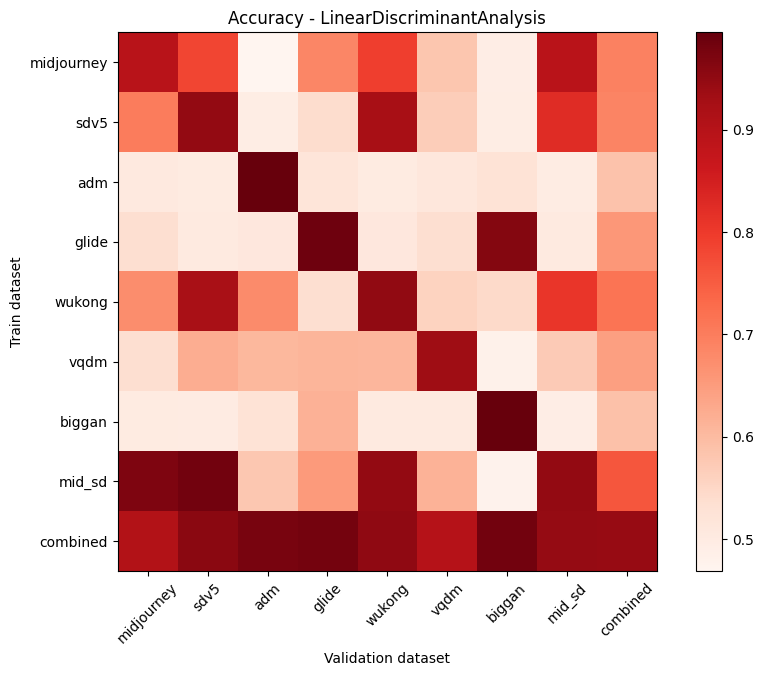

val_dataset,midjourney,sdv5,adm,glide,wukong,vqdm,biggan,mid_sd,combined
train_dataset,,,,,,,,,
midjourney,0.89500,0.78250,0.46875,0.68625,0.79250,0.58000,0.49250,0.892500,0.694464
sdv5,0.70125,0.94750,0.49375,0.53875,0.92125,0.56750,0.49500,0.825625,0.687857
adm,0.50625,0.50125,0.99375,0.52000,0.50000,0.51375,0.52500,0.497500,0.586786
glide,0.53625,0.50250,0.51000,0.98500,0.51125,0.53625,0.96375,0.502500,0.656250
wukong,0.67250,0.92000,0.67750,0.53625,0.94875,0.55875,0.54500,0.807500,0.713393
vqdm,0.53625,0.62250,0.60625,0.60875,0.60750,0.93500,0.48250,0.571875,0.645536
biggan,0.50000,0.49875,0.52500,0.61500,0.50250,0.50250,0.99500,0.491875,0.588571
mid_sd,0.97000,0.98125,0.57875,0.65250,0.94625,0.61375,0.47875,0.946875,0.759286
combined,0.90500,0.95750,0.97500,0.98000,0.95000,0.89875,0.98125,0.945000,0.942679


val_dataset,midjourney,sdv5,adm,glide,wukong,vqdm,biggan,mid_sd,average
train_dataset,,,,,,,,,
midjourney,0.89500,0.78250,0.46875,0.68625,0.79250,0.58000,0.49250,0.892500,0.698750
sdv5,0.70125,0.94750,0.49375,0.53875,0.92125,0.56750,0.49500,0.825625,0.686328
adm,0.50625,0.50125,0.99375,0.52000,0.50000,0.51375,0.52500,0.497500,0.569687
glide,0.53625,0.50250,0.51000,0.98500,0.51125,0.53625,0.96375,0.502500,0.630937
wukong,0.67250,0.92000,0.67750,0.53625,0.94875,0.55875,0.54500,0.807500,0.708281
vqdm,0.53625,0.62250,0.60625,0.60875,0.60750,0.93500,0.48250,0.571875,0.621328
biggan,0.50000,0.49875,0.52500,0.61500,0.50250,0.50250,0.99500,0.491875,0.578828
mid_sd,0.97000,0.98125,0.57875,0.65250,0.94625,0.61375,0.47875,0.946875,0.771016
combined,0.90500,0.95750,0.97500,0.98000,0.95000,0.89875,0.98125,0.945000,0.949062


In [24]:
df_pivot, df_avg = present_results(df, name="LinearDiscriminantAnalysis", cmap='Reds', evaluation_data_name="Validation", metric="accuracy")

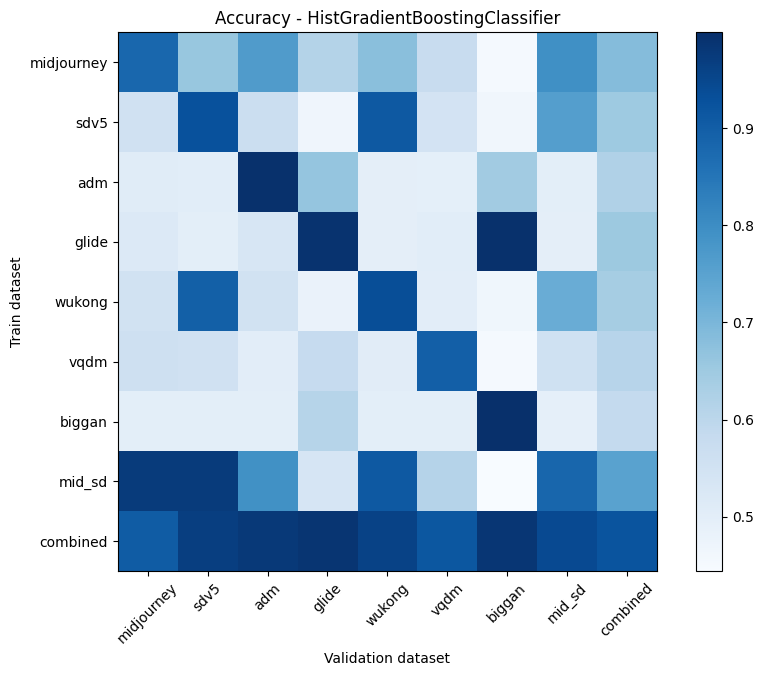

val_dataset,midjourney,sdv5,adm,glide,wukong,vqdm,biggan,mid_sd,combined
train_dataset,,,,,,,,,
midjourney,0.88000,0.66000,0.76500,0.61375,0.68000,0.57750,0.45125,0.793125,0.686071
sdv5,0.55250,0.92750,0.56875,0.46625,0.91125,0.54375,0.46250,0.758750,0.651429
adm,0.50875,0.50250,0.99625,0.66375,0.49750,0.49500,0.64375,0.498125,0.620714
glide,0.51750,0.49875,0.53375,0.99125,0.49750,0.50250,0.99500,0.497500,0.652679
wukong,0.55125,0.89500,0.55125,0.47875,0.93500,0.50125,0.46500,0.725000,0.638036
vqdm,0.56000,0.55375,0.50125,0.58125,0.50500,0.89875,0.45125,0.556250,0.607857
biggan,0.50000,0.50000,0.50000,0.61000,0.50000,0.50000,0.99875,0.491875,0.585714
mid_sd,0.97375,0.97375,0.79125,0.53625,0.91000,0.61125,0.44375,0.882500,0.750893
combined,0.90375,0.96625,0.97750,0.98750,0.95875,0.91625,0.98500,0.943750,0.920714


val_dataset,midjourney,sdv5,adm,glide,wukong,vqdm,biggan,mid_sd,average
train_dataset,,,,,,,,,
midjourney,0.88000,0.66000,0.76500,0.61375,0.68000,0.57750,0.45125,0.793125,0.677578
sdv5,0.55250,0.92750,0.56875,0.46625,0.91125,0.54375,0.46250,0.758750,0.648906
adm,0.50875,0.50250,0.99625,0.66375,0.49750,0.49500,0.64375,0.498125,0.600703
glide,0.51750,0.49875,0.53375,0.99125,0.49750,0.50250,0.99500,0.497500,0.629219
wukong,0.55125,0.89500,0.55125,0.47875,0.93500,0.50125,0.46500,0.725000,0.637813
vqdm,0.56000,0.55375,0.50125,0.58125,0.50500,0.89875,0.45125,0.556250,0.575937
biggan,0.50000,0.50000,0.50000,0.61000,0.50000,0.50000,0.99875,0.491875,0.575078
mid_sd,0.97375,0.97375,0.79125,0.53625,0.91000,0.61125,0.44375,0.882500,0.765313
combined,0.90375,0.96625,0.97750,0.98750,0.95875,0.91625,0.98500,0.943750,0.954844


In [25]:
df_pivot, df_avg = present_results(df, name="HistGradientBoostingClassifier", cmap='Blues', evaluation_data_name="Validation", metric="accuracy")

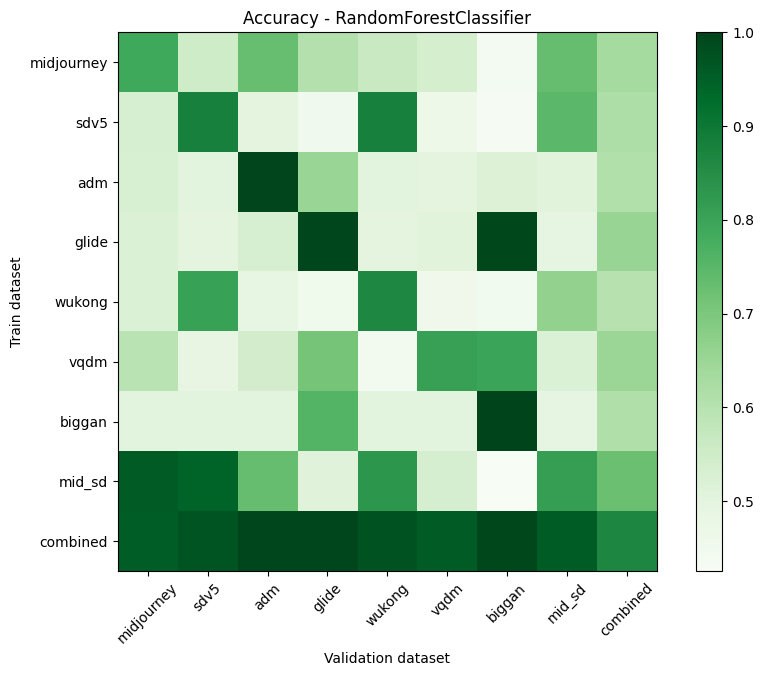

val_dataset,midjourney,sdv5,adm,glide,wukong,vqdm,biggan,mid_sd,combined
train_dataset,,,,,,,,,
midjourney,0.79000,0.55000,0.72875,0.60625,0.56625,0.53625,0.43875,0.730625,0.630893
sdv5,0.53125,0.87875,0.49875,0.45000,0.87875,0.46500,0.43375,0.748125,0.617857
adm,0.52625,0.50125,0.99625,0.65250,0.50000,0.49875,0.51750,0.504375,0.608036
glide,0.52125,0.49750,0.53125,0.99500,0.49750,0.50500,0.99250,0.494375,0.654821
wukong,0.52125,0.80500,0.48750,0.45500,0.86375,0.45750,0.44625,0.665000,0.599286
vqdm,0.59125,0.49000,0.54125,0.70875,0.44375,0.80875,0.79875,0.519375,0.648571
biggan,0.50000,0.50000,0.50000,0.75625,0.50000,0.50000,1.00000,0.491875,0.611607
mid_sd,0.95875,0.94375,0.73250,0.51000,0.83125,0.53375,0.42500,0.813125,0.723750
combined,0.95500,0.96875,0.99500,0.99375,0.97500,0.95750,0.99125,0.956250,0.865357


val_dataset,midjourney,sdv5,adm,glide,wukong,vqdm,biggan,mid_sd,average
train_dataset,,,,,,,,,
midjourney,0.79000,0.55000,0.72875,0.60625,0.56625,0.53625,0.43875,0.730625,0.618359
sdv5,0.53125,0.87875,0.49875,0.45000,0.87875,0.46500,0.43375,0.748125,0.610547
adm,0.52625,0.50125,0.99625,0.65250,0.50000,0.49875,0.51750,0.504375,0.587109
glide,0.52125,0.49750,0.53125,0.99500,0.49750,0.50500,0.99250,0.494375,0.629297
wukong,0.52125,0.80500,0.48750,0.45500,0.86375,0.45750,0.44625,0.665000,0.587656
vqdm,0.59125,0.49000,0.54125,0.70875,0.44375,0.80875,0.79875,0.519375,0.612734
biggan,0.50000,0.50000,0.50000,0.75625,0.50000,0.50000,1.00000,0.491875,0.593516
mid_sd,0.95875,0.94375,0.73250,0.51000,0.83125,0.53375,0.42500,0.813125,0.718516
combined,0.95500,0.96875,0.99500,0.99375,0.97500,0.95750,0.99125,0.956250,0.974063


In [27]:
df_pivot, df_avg = present_results(df, name="RandomForestClassifier", cmap='Greens', evaluation_data_name="Validation", metric="accuracy")

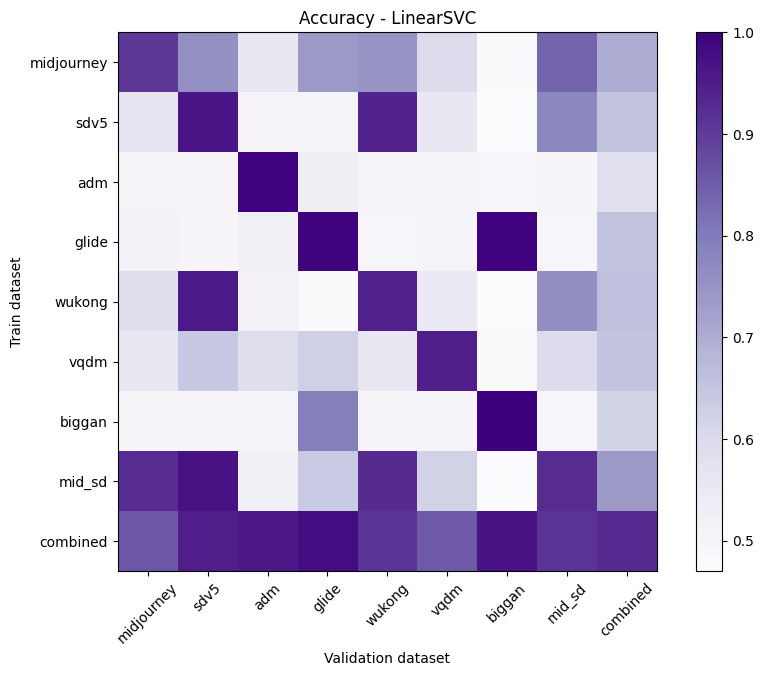

val_dataset,midjourney,sdv5,adm,glide,wukong,vqdm,biggan,mid_sd,combined
train_dataset,,,,,,,,,
midjourney,0.90625,0.75750,0.55625,0.73625,0.74750,0.60000,0.47750,0.838125,0.701071
sdv5,0.56250,0.96250,0.50500,0.50375,0.93875,0.55625,0.47250,0.775625,0.656250
adm,0.50625,0.50625,0.99500,0.53125,0.50000,0.50500,0.49500,0.500000,0.584821
glide,0.51750,0.50000,0.51875,0.99375,0.49875,0.50750,0.99625,0.497500,0.653929
wukong,0.58625,0.95500,0.51375,0.47875,0.94375,0.54750,0.47375,0.759375,0.660536
vqdm,0.55625,0.64250,0.58875,0.62625,0.55875,0.94750,0.48375,0.592500,0.650714
biggan,0.50125,0.50000,0.50125,0.79250,0.50000,0.50000,1.00000,0.492500,0.616964
mid_sd,0.92500,0.97000,0.52250,0.64000,0.92625,0.62000,0.47000,0.925000,0.736964
combined,0.85875,0.94625,0.95750,0.98125,0.91250,0.85500,0.96625,0.911875,0.928214


val_dataset,midjourney,sdv5,adm,glide,wukong,vqdm,biggan,mid_sd,average
train_dataset,,,,,,,,,
midjourney,0.90625,0.75750,0.55625,0.73625,0.74750,0.60000,0.47750,0.838125,0.702422
sdv5,0.56250,0.96250,0.50500,0.50375,0.93875,0.55625,0.47250,0.775625,0.659609
adm,0.50625,0.50625,0.99500,0.53125,0.50000,0.50500,0.49500,0.500000,0.567344
glide,0.51750,0.50000,0.51875,0.99375,0.49875,0.50750,0.99625,0.497500,0.628750
wukong,0.58625,0.95500,0.51375,0.47875,0.94375,0.54750,0.47375,0.759375,0.657266
vqdm,0.55625,0.64250,0.58875,0.62625,0.55875,0.94750,0.48375,0.592500,0.624531
biggan,0.50125,0.50000,0.50125,0.79250,0.50000,0.50000,1.00000,0.492500,0.598437
mid_sd,0.92500,0.97000,0.52250,0.64000,0.92625,0.62000,0.47000,0.925000,0.749844
combined,0.85875,0.94625,0.95750,0.98125,0.91250,0.85500,0.96625,0.911875,0.923672


In [28]:
df_pivot, df_avg = present_results(df, name="LinearSVC", cmap='Purples', evaluation_data_name="Validation", metric="accuracy")

## Evaluate on test data

In [40]:
X_test = {}
y_test = {}

for key, df in datasets_test.items():
    X_test[key] = df.drop('Category', axis=1)
    y_test[key] = df['Category']

In [41]:
results = {}
for dataset_name in models.keys():
    print(f"\n\n\n\n *** Evaluating models trained on {dataset_name}. ***")
    for test_dataset_name in X_test.keys():
        print(f"\n\nTest set: {test_dataset_name}")
        for model_name, model in models[dataset_name].items():
            print()  
            X_test_scaled = scalers[dataset_name].transform(X_test[test_dataset_name][X_train[dataset_name].columns])
            X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_train[dataset_name].columns)
            accuracy, f1, precision, recall, mcc = evaluate_model(model, X_test_scaled, y_test[test_dataset_name], name=model_name)
            model_results = {
                "accuracy": accuracy,
                "f1": f1,
                "precision": precision,
                "recall": recall,
                "mcc": mcc
            }
            results[(dataset_name, test_dataset_name, model_name)] = model_results
            
            





 *** Evaluating models trained on biggan. ***


Test set: biggan

Model: HistGradientBoostingClassifier
Accuracy: 0.9990
F1: 0.9990
Precision: 0.9990
Recall: 0.9990
MCC: 0.9980

Model: LinearDiscriminantAnalysis
Accuracy: 0.9920
F1: 0.9920
Precision: 0.9921
Recall: 0.9920
MCC: 0.9841

Model: RandomForestClassifier
Accuracy: 1.0000
F1: 1.0000
Precision: 1.0000
Recall: 1.0000
MCC: 1.0000

Model: LinearSVC
Accuracy: 1.0000
F1: 1.0000
Precision: 1.0000
Recall: 1.0000
MCC: 1.0000


Test set: vqdm



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5010
F1: 0.3373
Precision: 0.5836
Recall: 0.5010
MCC: 0.0183



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000


Test set: sdv5



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000


Test set: wukong



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5010
F1: 0.3373
Precision: 0.5836
Recall: 0.5010
MCC: 0.0183



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000


Test set: adm



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5160
F1: 0.3695
Precision: 0.7263
Recall: 0.5160
MCC: 0.1203

Model: RandomForestClassifier
Accuracy: 0.5010
F1: 0.3356
Precision: 0.7503
Recall: 0.5010
MCC: 0.0316

Model: LinearSVC
Accuracy: 0.5010
F1: 0.3356
Precision: 0.7503
Recall: 0.5010
MCC: 0.0316


Test set: glide

Model: HistGradientBoostingClassifier
Accuracy: 0.6190
F1: 0.5543
Precision: 0.7838
Recall: 0.6190
MCC: 0.3675

Model: LinearDiscriminantAnalysis
Accuracy: 0.5990
F1: 0.5240
Precision: 0.7679
Recall: 0.5990
MCC: 0.3257

Model: RandomForestClassifier
Accuracy: 0.7640
F1: 0.7501
Precision: 0.8397
Recall: 0.7640
MCC: 0.5989

Model: LinearSVC
Accuracy: 0.8010
F1: 0.7928
Precision: 0.8577
Recall: 0.8010
MCC: 0.6562


Test set: midjourney



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5030
F1: 0.3434
Precision: 0.6079
Recall: 0.5030
MCC: 0.0360



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5020
F1: 0.3378
Precision: 0.7505
Recall: 0.5020
MCC: 0.0448


Test set: mid_sd



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5015
F1: 0.3384
Precision: 0.6075
Recall: 0.5015
MCC: 0.0254



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5010
F1: 0.3356
Precision: 0.7503
Recall: 0.5010
MCC: 0.0316


Test set: combined

Model: HistGradientBoostingClassifier
Accuracy: 0.5883
F1: 0.5043
Precision: 0.7742
Recall: 0.5883
MCC: 0.3112

Model: LinearDiscriminantAnalysis
Accuracy: 0.5874
F1: 0.5038
Precision: 0.7684
Recall: 0.5874
MCC: 0.3064

Model: RandomForestClassifier
Accuracy: 0.6093
F1: 0.5389
Precision: 0.7807
Recall: 0.6093
MCC: 0.3503

Model: LinearSVC
Accuracy: 0.6149
F1: 0.5478
Precision: 0.7824
Recall: 0.6149
MCC: 0.3602




 *** Evaluating models trained on vqdm. ***


Test set: biggan

Model: HistGradientBoostingClassifier
Accuracy: 0.4740
F1: 0.3560
Precision: 0.4027
Recall: 0.4740
MCC: -0.1006

Model: LinearDiscriminantAnalysis
Accuracy: 0.4750
F1: 0.3511
Precision: 0.3941
Recall: 0.4750
MCC: -0.1029

Model: RandomForestClassifier
Accuracy: 0.8040
F1: 0.8038
Precision: 0.8051
Reca

d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000


Test set: wukong

Model: HistGradientBoostingClassifier
Accuracy: 0.4990
F1: 0.3329
Precision: 0.2497
Recall: 0.4990
MCC: -0.0316

Model: LinearDiscriminantAnalysis
Accuracy: 0.5230
F1: 0.3900
Precision: 0.6802
Recall: 0.5230
MCC: 0.1288

Model: RandomForestClassifier
Accuracy: 0.4970
F1: 0.3320
Precision: 0.2492
Recall: 0.4970
MCC: -0.0549

Model: LinearSVC
Accuracy: 0.5000
F1: 0.3351
Precision: 0.5000
Recall: 0.5000
MCC: 0.0000


Test set: adm

Model: HistGradientBoostingClassifier
Accuracy: 0.5280
F1: 0.3942
Precision: 0.7405
Recall: 0.5280
MCC: 0.1641

Model: LinearDiscriminantAnalysis
Accuracy: 0.5030
F1: 0.3485
Precision: 0.5585
Recall: 0.5030
MCC: 0.0265

Model: RandomForestClassifier
Accuracy: 0.5420
F1: 0.4231
Precision: 0.7393
Recall: 0.5420
MCC: 0.2005

Model: LinearSVC
Accuracy: 0.5270
F1: 0.3922
Precision: 0.7397
Recall: 0.5270
MCC: 0.1609


Test set: glide

Model: HistGradientBoost

In [42]:
# Create a heatmap of results
df = pd.DataFrame(results).T
df.reset_index(inplace=True)
df.columns = ["train_dataset", "test_dataset", "model", "accuracy", "f1", "precision", "recall", "mcc"]

df_pivot = df.pivot(index=["train_dataset", "model"], columns="test_dataset", values="accuracy")
df_pivot = df_pivot.reindex(index=X_train.keys())

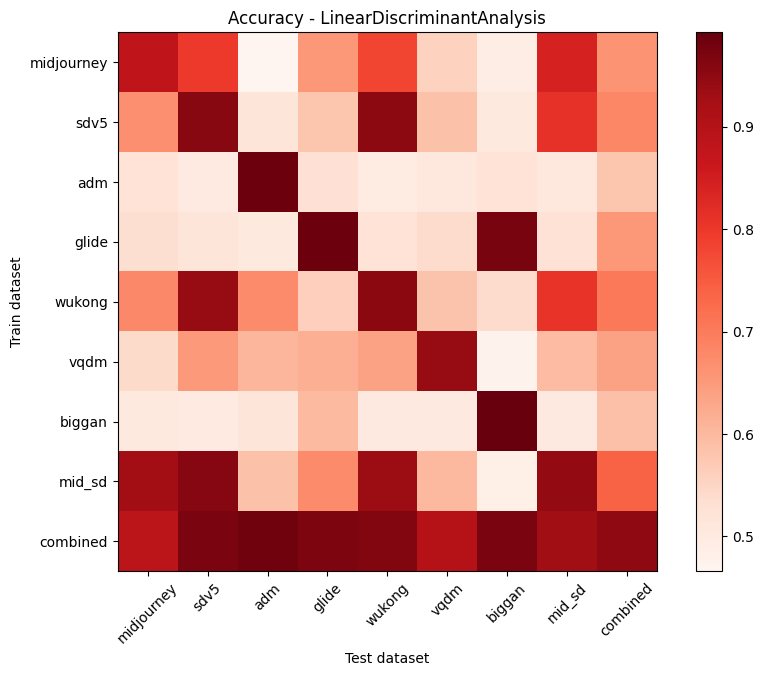

test_dataset,midjourney,sdv5,adm,glide,wukong,vqdm,biggan,mid_sd,combined
train_dataset,,,,,,,,,
midjourney,0.883,0.797,0.466,0.655,0.780,0.556,0.491,0.8400,0.661143
sdv5,0.669,0.956,0.516,0.581,0.950,0.586,0.503,0.8125,0.680143
adm,0.522,0.499,0.984,0.527,0.496,0.511,0.522,0.5105,0.580143
glide,0.533,0.515,0.503,0.985,0.523,0.539,0.973,0.5240,0.653000
wukong,0.678,0.940,0.675,0.562,0.951,0.583,0.538,0.8090,0.703857
vqdm,0.540,0.652,0.604,0.616,0.637,0.939,0.475,0.5960,0.637571
biggan,0.503,0.500,0.516,0.599,0.501,0.501,0.992,0.5015,0.587429
mid_sd,0.928,0.959,0.586,0.674,0.936,0.601,0.486,0.9435,0.738571
combined,0.886,0.971,0.980,0.969,0.962,0.897,0.970,0.9285,0.947857


test_dataset,midjourney,sdv5,adm,glide,wukong,vqdm,biggan,mid_sd,average
train_dataset,,,,,,,,,
midjourney,0.883,0.797,0.466,0.655,0.780,0.556,0.491,0.8400,0.683500
sdv5,0.669,0.956,0.516,0.581,0.950,0.586,0.503,0.8125,0.696688
adm,0.522,0.499,0.984,0.527,0.496,0.511,0.522,0.5105,0.571438
glide,0.533,0.515,0.503,0.985,0.523,0.539,0.973,0.5240,0.636875
wukong,0.678,0.940,0.675,0.562,0.951,0.583,0.538,0.8090,0.717000
vqdm,0.540,0.652,0.604,0.616,0.637,0.939,0.475,0.5960,0.632375
biggan,0.503,0.500,0.516,0.599,0.501,0.501,0.992,0.5015,0.576688
mid_sd,0.928,0.959,0.586,0.674,0.936,0.601,0.486,0.9435,0.764188
combined,0.886,0.971,0.980,0.969,0.962,0.897,0.970,0.9285,0.945437


In [43]:
df_pivot, df_avg = present_results(df, name="LinearDiscriminantAnalysis", cmap='Reds', evaluation_data_name="Test", metric="accuracy")

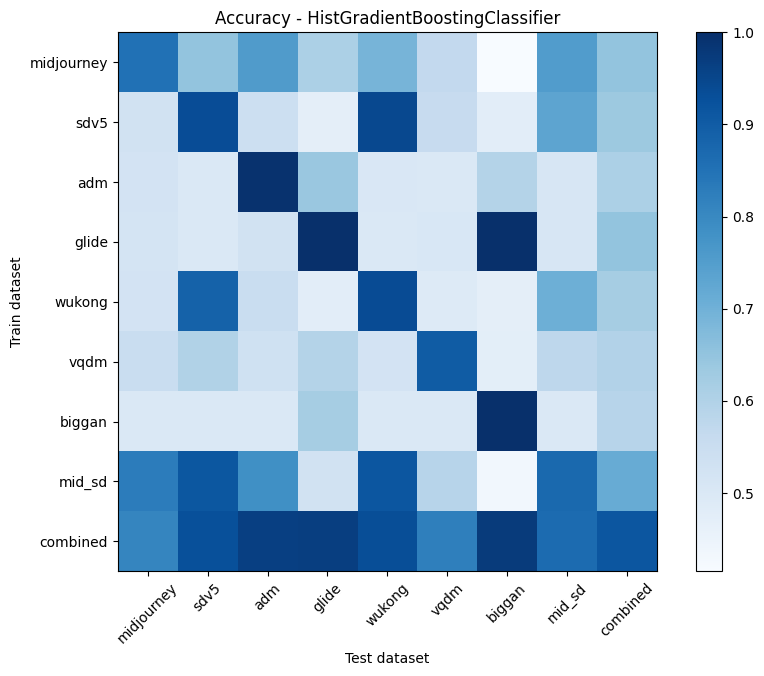

test_dataset,midjourney,sdv5,adm,glide,wukong,vqdm,biggan,mid_sd,combined
train_dataset,,,,,,,,,
midjourney,0.852,0.650,0.755,0.608,0.690,0.567,0.415,0.7510,0.648143
sdv5,0.529,0.936,0.542,0.471,0.944,0.557,0.475,0.7325,0.636286
adm,0.521,0.498,0.995,0.641,0.504,0.500,0.594,0.5095,0.607571
glide,0.520,0.499,0.528,0.998,0.499,0.506,1.000,0.5095,0.650000
wukong,0.522,0.888,0.550,0.475,0.937,0.490,0.472,0.7050,0.619143
vqdm,0.551,0.600,0.533,0.595,0.522,0.900,0.474,0.5755,0.596429
biggan,0.500,0.500,0.500,0.619,0.500,0.500,0.999,0.5000,0.588286
mid_sd,0.827,0.913,0.783,0.528,0.915,0.587,0.433,0.8700,0.712286
combined,0.807,0.927,0.964,0.968,0.933,0.821,0.974,0.8670,0.913429


test_dataset,midjourney,sdv5,adm,glide,wukong,vqdm,biggan,mid_sd,average
train_dataset,,,,,,,,,
midjourney,0.852,0.650,0.755,0.608,0.690,0.567,0.415,0.7510,0.661000
sdv5,0.529,0.936,0.542,0.471,0.944,0.557,0.475,0.7325,0.648312
adm,0.521,0.498,0.995,0.641,0.504,0.500,0.594,0.5095,0.595313
glide,0.520,0.499,0.528,0.998,0.499,0.506,1.000,0.5095,0.632437
wukong,0.522,0.888,0.550,0.475,0.937,0.490,0.472,0.7050,0.629875
vqdm,0.551,0.600,0.533,0.595,0.522,0.900,0.474,0.5755,0.593813
biggan,0.500,0.500,0.500,0.619,0.500,0.500,0.999,0.5000,0.577250
mid_sd,0.827,0.913,0.783,0.528,0.915,0.587,0.433,0.8700,0.732000
combined,0.807,0.927,0.964,0.968,0.933,0.821,0.974,0.8670,0.907625


In [44]:
df_pivot, df_avg = present_results(df, name="HistGradientBoostingClassifier", cmap='Blues', evaluation_data_name="Test", metric="accuracy")

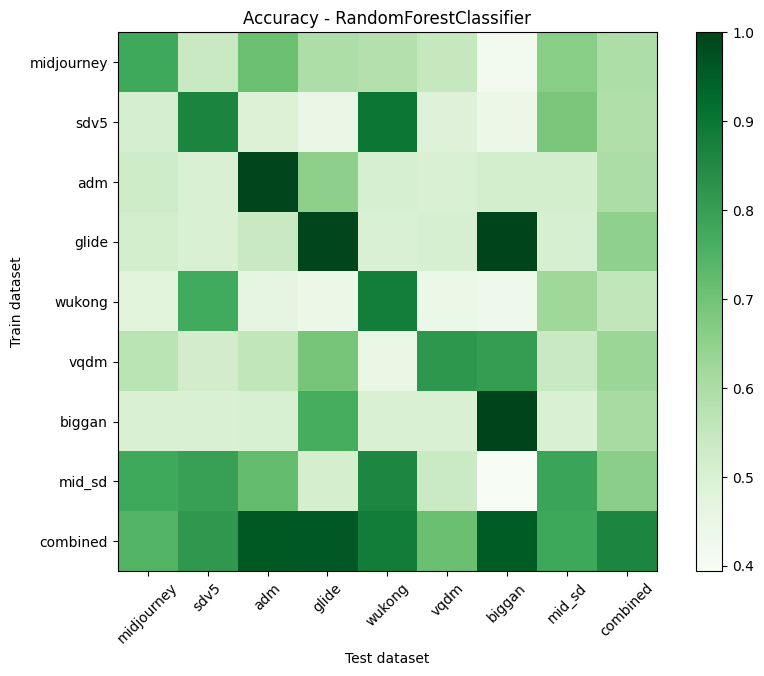

test_dataset,midjourney,sdv5,adm,glide,wukong,vqdm,biggan,mid_sd,combined
train_dataset,,,,,,,,,
midjourney,0.776,0.543,0.708,0.596,0.585,0.548,0.415,0.6595,0.595857
sdv5,0.509,0.864,0.491,0.453,0.896,0.485,0.444,0.6865,0.591714
adm,0.529,0.499,0.997,0.654,0.503,0.499,0.514,0.5140,0.599286
glide,0.513,0.499,0.542,0.996,0.497,0.506,0.998,0.5060,0.650143
wukong,0.476,0.771,0.466,0.445,0.881,0.443,0.431,0.6235,0.559000
vqdm,0.568,0.515,0.558,0.691,0.457,0.818,0.804,0.5415,0.630143
biggan,0.500,0.500,0.501,0.764,0.500,0.500,1.000,0.5000,0.609286
mid_sd,0.777,0.797,0.720,0.512,0.858,0.540,0.394,0.7870,0.656857
combined,0.745,0.816,0.962,0.959,0.884,0.709,0.954,0.7805,0.861286


test_dataset,midjourney,sdv5,adm,glide,wukong,vqdm,biggan,mid_sd,average
train_dataset,,,,,,,,,
midjourney,0.776,0.543,0.708,0.596,0.585,0.548,0.415,0.6595,0.603812
sdv5,0.509,0.864,0.491,0.453,0.896,0.485,0.444,0.6865,0.603563
adm,0.529,0.499,0.997,0.654,0.503,0.499,0.514,0.5140,0.588625
glide,0.513,0.499,0.542,0.996,0.497,0.506,0.998,0.5060,0.632125
wukong,0.476,0.771,0.466,0.445,0.881,0.443,0.431,0.6235,0.567063
vqdm,0.568,0.515,0.558,0.691,0.457,0.818,0.804,0.5415,0.619062
biggan,0.500,0.500,0.501,0.764,0.500,0.500,1.000,0.5000,0.595625
mid_sd,0.777,0.797,0.720,0.512,0.858,0.540,0.394,0.7870,0.673125
combined,0.745,0.816,0.962,0.959,0.884,0.709,0.954,0.7805,0.851187


In [48]:
df_pivot, df_avg = present_results(df, name="RandomForestClassifier", cmap='Greens', evaluation_data_name="Test", metric="accuracy")

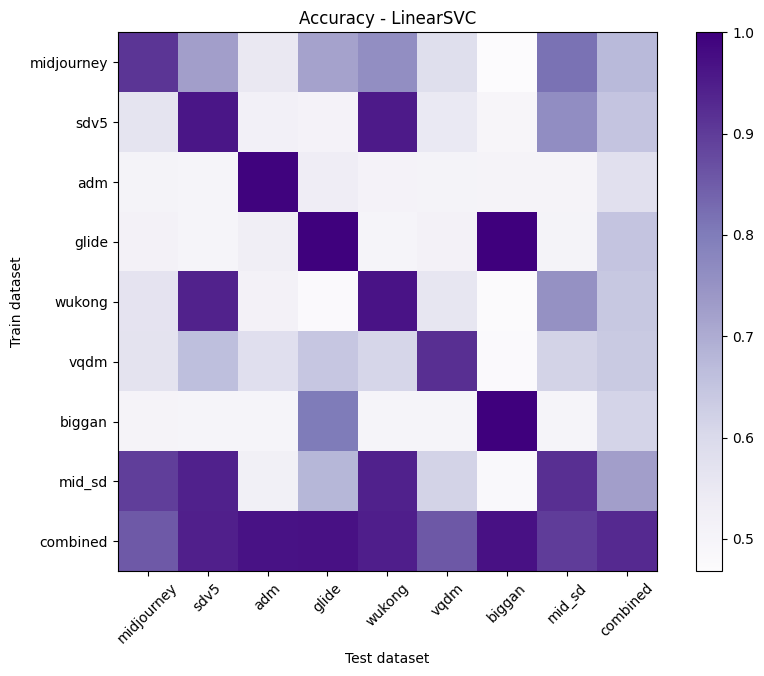

test_dataset,midjourney,sdv5,adm,glide,wukong,vqdm,biggan,mid_sd,combined
train_dataset,,,,,,,,,
midjourney,0.909,0.724,0.550,0.719,0.761,0.583,0.468,0.8165,0.673429
sdv5,0.565,0.961,0.517,0.508,0.953,0.548,0.493,0.7630,0.649286
adm,0.507,0.500,0.993,0.532,0.509,0.507,0.503,0.5035,0.578714
glide,0.512,0.500,0.527,0.996,0.500,0.514,0.999,0.5060,0.649714
wukong,0.567,0.941,0.513,0.475,0.966,0.558,0.473,0.7540,0.641857
vqdm,0.569,0.663,0.582,0.646,0.611,0.920,0.476,0.6160,0.638143
biggan,0.502,0.500,0.501,0.801,0.500,0.500,1.000,0.5010,0.614857
mid_sd,0.895,0.943,0.522,0.679,0.942,0.616,0.482,0.9190,0.725571
combined,0.853,0.944,0.967,0.970,0.946,0.855,0.970,0.8985,0.929286


test_dataset,midjourney,sdv5,adm,glide,wukong,vqdm,biggan,mid_sd,average
train_dataset,,,,,,,,,
midjourney,0.909,0.724,0.550,0.719,0.761,0.583,0.468,0.8165,0.691312
sdv5,0.565,0.961,0.517,0.508,0.953,0.548,0.493,0.7630,0.663500
adm,0.507,0.500,0.993,0.532,0.509,0.507,0.503,0.5035,0.569312
glide,0.512,0.500,0.527,0.996,0.500,0.514,0.999,0.5060,0.631750
wukong,0.567,0.941,0.513,0.475,0.966,0.558,0.473,0.7540,0.655875
vqdm,0.569,0.663,0.582,0.646,0.611,0.920,0.476,0.6160,0.635375
biggan,0.502,0.500,0.501,0.801,0.500,0.500,1.000,0.5010,0.600625
mid_sd,0.895,0.943,0.522,0.679,0.942,0.616,0.482,0.9190,0.749750
combined,0.853,0.944,0.967,0.970,0.946,0.855,0.970,0.8985,0.925438


In [49]:
df_pivot, df_avg = present_results(df, name="LinearSVC", cmap='Purples', evaluation_data_name="Test", metric="accuracy")

## Save models and scalers

In [50]:
# for each dataset save models and scalers
# import joblib

# for dataset_name in models.keys():
#     for model_name, model in models[dataset_name].items():
#         models_dir_path = f"models/GenImage/standard/{dataset_name}"
#         scalers_dir_path = f"scalers/GenImage/standard/{dataset_name}"
#         os.makedirs(models_dir_path, exist_ok=True)
#         os.makedirs(scalers_dir_path, exist_ok=True)
#         joblib.dump(model, os.path.join(models_dir_path, f"{dataset_name}_{model_name}.joblib"))
#         joblib.dump(scalers[dataset_name], os.path.join(scalers_dir_path, f"{dataset_name}_{model_name}.joblib"))